In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import warnings
import requests
from bs4 import BeautifulSoup
warnings.filterwarnings('ignore')

### This project uses data from three different sources, all from the same time period: the years 2017,2018, and 2019. The first data source is an Excel file of NFL Combine data compiled from https://nflcombineresults.com/. The second source contains NFL draft data scraped from https://www.pro-football-reference.com. The third source contains NFL Fantasy data retrieved from the API of https://www.fantasyfootballdatapros.com/.

### ***Data Source 1:*** Three years (2017,2018,2019) of NFL Combine Data compiled from https://nflcombineresults.com/.

In [2]:
# First we import the file, create the dataframe, and view the dataframe head
df = pd.read_excel(r'C:\Users\dlbry\Downloads\ThinkStats2-master\code\NFL Combine Data.xlsx')

In [3]:
df.head()

,Year,Name,College,POS,Height (in),Weight (lbs),Hand Size (in),Arm Length (in),Wonderlic,40 Yard,Bench Press,Vert Leap (in),Broad Jump (in),Shuttle,3Cone,60Yd Shuttle
0,1987,Rod Woodson,Purdue,CB,72.0,202,10.50,31.00,NaN,4.33,10.0,36.0,125.0,3.98,NaN,10.92
1,1987,Greg Richardson,Alabama,WR,67.3,164,NaN,NaN,NaN,4.35,1.0,28.0,113.0,4.21,NaN,11.54
2,1987,Eric Thomas,Tulane (LA),CB,70.3,171,8.25,30.75,NaN,4.38,7.0,35.0,126.0,4.22,NaN,11.58
3,1987,Ricky Nattiel,Florida,WR,68.9,178,NaN,NaN,NaN,4.41,NaN,32.0,116.0,NaN,NaN,NaN
4,1987,Haywood Jeffires,North Carolina State,WR,74.1,191,9.00,33.00,NaN,4.41,NaN,NaN,NaN,NaN,NaN,NaN


#### We only want data from the years 2017, 2018, and 2019 so we will filter the dataframe to include only these values.

In [4]:
df_combine_data = df[df['Year'].isin([2017, 2018, 2019])]

In [5]:
# We reset the index of the new df
df_combine_data.reset_index(inplace = True, drop = True) 

# View the new dataframe info
df_combine_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 939 entries, 0 to 938
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Year             939 non-null    int64  
 1   Name             939 non-null    object 
 2   College          939 non-null    object 
 3   POS              939 non-null    object 
 4   Height (in)      939 non-null    float64
 5   Weight (lbs)     939 non-null    int64  
 6   Hand Size (in)   797 non-null    float64
 7   Arm Length (in)  797 non-null    float64
 8   Wonderlic        75 non-null     float64
 9   40 Yard          733 non-null    float64
 10  Bench Press      692 non-null    float64
 11  Vert Leap (in)   732 non-null    float64
 12  Broad Jump (in)  721 non-null    float64
 13  Shuttle          621 non-null    float64
 14  3Cone            542 non-null    float64
 15  60Yd Shuttle     136 non-null    float64
dtypes: float64(11), int64(2), object(3)
memory usage: 117.5+ KB


#### We will rename the columns to remove spaces.

In [6]:
df_combine_data.columns = ['Year', 'Name', 'College', 'POS', 'Height', 'Weight',
       'Hand_Size', 'Arm_Length', 'Wonderlic', 'Forty_Yard',
       'Bench_Press', 'Vert_Leap', 'Broad_Jump', 'Shuttle', '3Cone', '60Yd_Shuttle']

#### We will delete the Wonderlic and College variables as we will not be using them. We will delete the 3Cone and 60Yd_Shuttle variables due to low participation and similarity to the Shuttle.  

In [7]:
df_combine_data.drop(['College', 'Wonderlic', '3Cone', '60Yd_Shuttle']
                     , axis=1, inplace=True)

In [8]:
df_combine_data.POS.unique()

array(['WR', 'CB', 'RB', 'DB', 'FS', 'SS', 'TE', 'LB', 'DE', 'OLB', 'QB',
       'P', 'DL', 'ILB', 'FB', 'K', 'OT', 'DT', 'OG', 'C', 'OL', 'LS',
       'NT', 'S', 'EDG'], dtype=object)

#### We will consolidate the player positions with the following changes:  
Nose Tackle (NT) --> Defensive Tackle (DT)  
Defensive back (DB) --> Cornerback (CB)  
Edge rusher (EDG) --> Outside Linebacker (OLB)  
Defensive Line (DL) --> Defensive Tackle (DT)  
Safety (S) --> Strong Safety (SS)  
Offensive Line (OL) --> Offensive Guard (OG)  
Linebacker (LB) --> Inside Linebacker (ILB).

In [9]:
# Consolidate position names.
old_values = ['NT','DB','EDG','DL','S','OL','LB']
new_values = ['DT','CB','OLB','DT','SS','OG','ILB']

zipped = zip(old_values, new_values)

for i,j in zipped:
    df_combine_data['POS'].replace(to_replace=i, value=j, inplace=True) 

### ***Data Source 2:***  Three years (2017,2018,2019) of NFL draft data scraped from https://www.pro-football-reference.com. 
The format for each draft year's URL is "https://www.pro-football-reference.com/years/{year}/draft.htm" where {year} is substituted for the desired year of the draft. To scrape the three years, we create a list of the draft years and run a for loop to create a URL for each year. Then we create a response object using a get request for each URL and then pass that response to BeautifulSoup to create a bs4 object. After inspecting the webpage, we find that the table we want is id="drafts". We create a table from this data by searching for 'table', {'id': 'drafts'} in the soup object (see snapshot below).

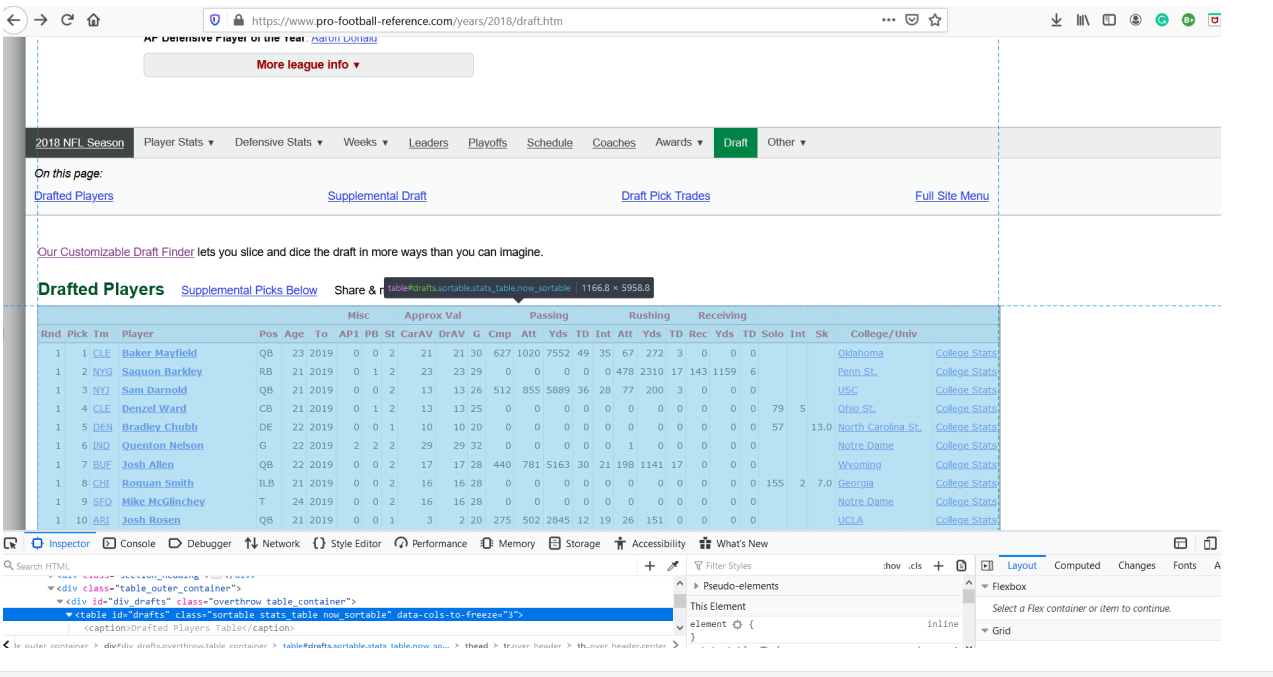

In [10]:
# Inspect the webpage, and look for the table we need.
from IPython.display import Image
Image(filename=r'C:\Users\dlbry\OneDrive\Pictures/pro football reference web scrape.png')

In [11]:
# Create an empty list to store each df
list_of_df = []
for year in [2017,2018,2019]:
    url = "https://www.pro-football-reference.com/years/{year}/draft.htm".format(year=year)
    response = requests.get(url)
    soup = BeautifulSoup(response.content, 'html.parser')
    table = soup.find('table', {'id': 'drafts'})
    df = pd.read_html(str(table))[0]
    
    # We will drop the first level of the headers
    df.columns = df.columns.droplevel(level = 0)
    
    # There are multiple rows of the column names for readability but they must be removed.
    df = df[df['Pos'] != 'Pos']
    
    # We want to store the year each player was drafted into that draft year's df.
    # The current table stores the most recently played season. To update this with the correct value,
    # we set the 'To' column = year, which is the draft year the player was selected.
    df['To'] = year
    list_of_df.append(df)

In [12]:
# We concatenate the three dataframes together
df_draft_data = pd.concat(list_of_df, sort=False)

In [13]:
df_draft_data.head()

,Rnd,Pick,Tm,Player,Pos,Age,To,AP1,PB,St,...,Yds,TD,Rec,Yds,TD,Solo,Int,Sk,College/Univ,Unnamed: 28_level_1
0,1,1,CLE,Myles Garrett,DE,21,2017,0,1,3,...,0,0,0,0,0,74,NaN,30.5,Texas A&M,College Stats
1,1,2,CHI,Mitchell Trubisky,QB,23,2017,0,1,3,...,862,7,0,0,0,NaN,NaN,NaN,North Carolina,College Stats
2,1,3,SFO,Solomon Thomas,DE,22,2017,0,0,2,...,0,0,0,0,0,73,NaN,6.0,Stanford,College Stats
3,1,4,JAX,Leonard Fournette,RB,22,2017,0,0,3,...,2631,17,134,1009,2,NaN,NaN,NaN,LSU,College Stats
4,1,5,TEN,Corey Davis,WR,22,2017,0,0,3,...,55,0,142,1867,6,NaN,NaN,NaN,West. Michigan,College Stats


In [14]:
# Inspect the columns of the df
df_draft_data.columns

Index(['Rnd', 'Pick', 'Tm', 'Player', 'Pos', 'Age', 'To', 'AP1', 'PB', 'St',
       'CarAV', 'DrAV', 'G', 'Cmp', 'Att', 'Yds', 'TD', 'Int', 'Att', 'Yds',
       'TD', 'Rec', 'Yds', 'TD', 'Solo', 'Int', 'Sk', 'College/Univ',
       'Unnamed: 28_level_1'],
      dtype='object')

#### The headers were imported automatically as part of the table web scrape. If we wanted to extract only the headers from the webpage, we would use the following code.

In [15]:
match = soup.find('thead').find_all('th')
headers = [match[i].get_text().strip() for i in range(12,41)]
headers

['Rnd',
 'Pick',
 'Tm',
 'Player',
 'Pos',
 'Age',
 'To',
 'AP1',
 'PB',
 'St',
 'CarAV',
 'DrAV',
 'G',
 'Cmp',
 'Att',
 'Yds',
 'TD',
 'Int',
 'Att',
 'Yds',
 'TD',
 'Rec',
 'Yds',
 'TD',
 'Solo',
 'Int',
 'Sk',
 'College/Univ',
 '']

#### We want to update the headers since some are ambiguous, and some are repeated due to the multi-leveled table header. Looking at the webpage, the first set of 'Att', 'Yds', and 'TD' headers should be passing statistics. The second set of 'Att', 'Yds', and 'TD' headers should be rushing statistics. The third set of 'Yds' and 'TD' headers should be receiving statistics. We will also change the headers to have more meaningful names.


In [16]:
# Renaming headers - We will save the headers as our column names when we are finished.
headers[2] = 'Team'
headers[6] = 'Draft_year'
headers[13] = 'Pass_comp'
headers[14] = 'Pass_att'
headers[15] = 'Pass_yds'
headers[16] = 'Pass_TD'
headers[17] = 'Pass_Int'
headers[18] = 'Rush_att'
headers[19] = 'Rush_yds'
headers[20] = 'Rush_TD'
headers[21] = 'Receptions'
headers[22] = 'Rec_yds'
headers[23] = 'Rec_TD'
headers[24] = 'Def_Tackles'
headers[25] = 'Def_Int'
headers[26] = 'Def_Sacks'
headers[27] = 'College'

In [17]:
headers

['Rnd',
 'Pick',
 'Team',
 'Player',
 'Pos',
 'Age',
 'Draft_year',
 'AP1',
 'PB',
 'St',
 'CarAV',
 'DrAV',
 'G',
 'Pass_comp',
 'Pass_att',
 'Pass_yds',
 'Pass_TD',
 'Pass_Int',
 'Rush_att',
 'Rush_yds',
 'Rush_TD',
 'Receptions',
 'Rec_yds',
 'Rec_TD',
 'Def_Tackles',
 'Def_Int',
 'Def_Sacks',
 'College',
 '']

In [18]:
# Set the column names = headers
df_draft_data.columns = headers
df_draft_data.columns

Index(['Rnd', 'Pick', 'Team', 'Player', 'Pos', 'Age', 'Draft_year', 'AP1',
       'PB', 'St', 'CarAV', 'DrAV', 'G', 'Pass_comp', 'Pass_att', 'Pass_yds',
       'Pass_TD', 'Pass_Int', 'Rush_att', 'Rush_yds', 'Rush_TD', 'Receptions',
       'Rec_yds', 'Rec_TD', 'Def_Tackles', 'Def_Int', 'Def_Sacks', 'College',
       ''],
      dtype='object')

In [19]:
# Drop the blank header
df_draft_data.drop(['','AP1','PB','St','CarAV','DrAV'], axis=1, inplace=True)
df_draft_data.columns


Index(['Rnd', 'Pick', 'Team', 'Player', 'Pos', 'Age', 'Draft_year', 'G',
       'Pass_comp', 'Pass_att', 'Pass_yds', 'Pass_TD', 'Pass_Int', 'Rush_att',
       'Rush_yds', 'Rush_TD', 'Receptions', 'Rec_yds', 'Rec_TD', 'Def_Tackles',
       'Def_Int', 'Def_Sacks', 'College'],
      dtype='object')

In [20]:
# Check the data types 
df_draft_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 763 entries, 0 to 259
Data columns (total 23 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Rnd          763 non-null    object
 1   Pick         763 non-null    object
 2   Team         763 non-null    object
 3   Player       763 non-null    object
 4   Pos          763 non-null    object
 5   Age          763 non-null    object
 6   Draft_year   763 non-null    int64 
 7   G            675 non-null    object
 8   Pass_comp    675 non-null    object
 9   Pass_att     675 non-null    object
 10  Pass_yds     675 non-null    object
 11  Pass_TD      675 non-null    object
 12  Pass_Int     675 non-null    object
 13  Rush_att     675 non-null    object
 14  Rush_yds     675 non-null    object
 15  Rush_TD      675 non-null    object
 16  Receptions   675 non-null    object
 17  Rec_yds      675 non-null    object
 18  Rec_TD       675 non-null    object
 19  Def_Tackles  417 non-null    

#### We want all but 4 of our columns data types to be numeric. To do that, we make a list of the columns to exclude from the conversion and then subtract them from the columns list. Then we will apply pd.to_numeric to change the desired columns' data types to numeric.

In [21]:
cols_to_exclude = ['Team','Player','Pos','College']
final_list= list(set(df_draft_data.columns).difference(set(cols_to_exclude)))
final_list

['Rush_TD',
 'Pass_yds',
 'Rush_yds',
 'Def_Tackles',
 'Pass_comp',
 'Rush_att',
 'Rec_yds',
 'Draft_year',
 'Pick',
 'Rnd',
 'Def_Sacks',
 'Pass_Int',
 'Def_Int',
 'Pass_TD',
 'Receptions',
 'Age',
 'G',
 'Rec_TD',
 'Pass_att']

In [22]:
# Change multiple column data types to numeric using apply and reset the index.
df_draft_data[final_list] = df_draft_data[final_list].apply(pd.to_numeric)
df_draft_data.reset_index(inplace = True, drop = True) 

# Confirm the data type changes in the df
df_draft_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 763 entries, 0 to 762
Data columns (total 23 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Rnd          763 non-null    int64  
 1   Pick         763 non-null    int64  
 2   Team         763 non-null    object 
 3   Player       763 non-null    object 
 4   Pos          763 non-null    object 
 5   Age          763 non-null    int64  
 6   Draft_year   763 non-null    int64  
 7   G            675 non-null    float64
 8   Pass_comp    675 non-null    float64
 9   Pass_att     675 non-null    float64
 10  Pass_yds     675 non-null    float64
 11  Pass_TD      675 non-null    float64
 12  Pass_Int     675 non-null    float64
 13  Rush_att     675 non-null    float64
 14  Rush_yds     675 non-null    float64
 15  Rush_TD      675 non-null    float64
 16  Receptions   675 non-null    float64
 17  Rec_yds      675 non-null    float64
 18  Rec_TD       675 non-null    float64
 19  Def_Tack

### ***Data source 3:*** Three years (2017,2018,2019) of NFL fantasy stats from the open API at https://www.fantasyfootballdatapros.com. 
The format for each draft year's URL is https://www.fantasyfootballdatapros.com/api/players/{year}/all, where {year} is substituted for the desired year of the fantasy stats. We create a list of the draft years and run a for loop to generate a URL for each year. For each year, we call the API using a get request and create a response object. We then extract the JSON data using.json() on the response object. We then use the pd.json_normalize() method on the data to create a data frame from the nested JSON data. We append the data frames to create a list of three data frames.


In [23]:
list_of_fantasy_df = []
for year in [2017,2018,2019]:
    url = "https://www.fantasyfootballdatapros.com/api/players/{year}/all".format(year=year)
    response = requests.get(url)
    data = response.json()
    df = pd.json_normalize(data)
    
    # Data cleansing step 1 - There is no column to track the year of the stats, so we will add a blank column first.
    # We insert the column as the first column in the dataframe.    
    df.insert(0,'stats_year','')
    
    # Next we will assign the column to be equal to the year of the season in which the stats were accrued.
    df['stats_year'] = year
    
    df = df.drop_duplicates(subset = ["player_name"])
    
    # Append each data frame to the list
    list_of_fantasy_df.append(df)

In [24]:
# We concatenate the three dataframes together
df_fantasy_data = pd.concat(list_of_fantasy_df, sort=False)

In [25]:
df_fantasy_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1810 entries, 0 to 619
Data columns (total 18 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   stats_year                     1810 non-null   int64  
 1   fumbles_lost                   1810 non-null   float64
 2   games_played                   1810 non-null   float64
 3   player_name                    1810 non-null   object 
 4   position                       1810 non-null   object 
 5   team                           1810 non-null   object 
 6   stats.passing.int              1810 non-null   float64
 7   stats.passing.passing_att      1810 non-null   float64
 8   stats.passing.passing_cmp      1810 non-null   float64
 9   stats.passing.passing_td       1810 non-null   float64
 10  stats.passing.passing_yds      1810 non-null   float64
 11  stats.receiving.receiving_td   1810 non-null   float64
 12  stats.receiving.receiving_yds  1810 non-null   fl

In [26]:
df_fantasy_data.head()

,stats_year,fumbles_lost,games_played,player_name,position,team,stats.passing.int,stats.passing.passing_att,stats.passing.passing_cmp,stats.passing.passing_td,stats.passing.passing_yds,stats.receiving.receiving_td,stats.receiving.receiving_yds,stats.receiving.receptions,stats.receiving.targets,stats.rushing.rushing_att,stats.rushing.rushing_td,stats.rushing.rushing_yds
0,2017,2.0,15.0,Todd Gurley,RB,LAR,0.0,0.0,0.0,0.0,0.0,6.0,788.0,64.0,87.0,279.0,13.0,1305.0
1,2017,2.0,15.0,Le'Veon Bell,RB,PIT,0.0,0.0,0.0,0.0,0.0,2.0,655.0,85.0,106.0,321.0,9.0,1291.0
2,2017,1.0,16.0,Kareem Hunt,RB,KAN,0.0,0.0,0.0,0.0,0.0,3.0,455.0,53.0,63.0,272.0,8.0,1327.0
3,2017,1.0,16.0,Alvin Kamara,RB,NOR,0.0,0.0,0.0,0.0,0.0,5.0,826.0,81.0,100.0,120.0,8.0,728.0
4,2017,0.0,16.0,Melvin Gordon,RB,LAC,0.0,0.0,0.0,0.0,0.0,4.0,476.0,58.0,83.0,284.0,8.0,1105.0


### Due to the way that .json_normalize() unpacks the nested JSON, the column names are messy and ambiguous. We will rename them for more clarity.

In [27]:
# Rename column names
df_fantasy_data.columns = df_fantasy_data.columns.str.replace(r"stats.passing.", "")
df_fantasy_data.columns = df_fantasy_data.columns.str.replace(r"stats.receiving.", "")
df_fantasy_data.columns = df_fantasy_data.columns.str.replace(r"stats.rushing.", "")

In [28]:
df_fantasy_data.columns

Index(['stats_year', 'fumbles_lost', 'games_played', 'player_name', 'position',
       'team', 'int', 'passing_att', 'passing_cmp', 'passing_td',
       'passing_yds', 'receiving_td', 'receiving_yds', 'receptions', 'targets',
       'rushing_att', 'rushing_td', 'rushing_yds'],
      dtype='object')

### Next, we will examine the position column.

In [29]:
df_fantasy_data['position'].value_counts()

WR    626
RB    466
TE    342
QB    216
0     160
Name: position, dtype: int64

### From above, we can see that WR, RB, TE, and QB are all featured in the fantasy stats, which makes sense. What doesn't make sense is that there is a position named 0. We will use a pivot_table to inspect the stats of the positions.

In [30]:
# We can check the fantasy stats for each position by using 'position' as the index of a pivot table
table = pd.pivot_table(data=df_fantasy_data,index=['position'])
table

,fumbles_lost,games_played,int,passing_att,passing_cmp,passing_td,passing_yds,receiving_td,receiving_yds,receptions,rushing_att,rushing_td,rushing_yds,stats_year,targets
position,,,,,,,,,,,,,,,
0,0.043750,4.868750,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2018.200000,0.218750
QB,1.648148,8.606481,5.777778,244.856481,155.449074,10.939815,1761.361111,0.046296,1.467593,0.208333,24.731481,1.004630,106.060185,2017.986111,0.282407
RB,0.500000,11.562232,0.006438,0.045064,0.027897,0.006438,0.381974,0.701717,140.478541,17.517167,72.562232,2.165236,305.251073,2017.989270,23.137339
TE,0.146199,12.426901,0.002924,0.011696,0.002924,0.000000,0.043860,1.704678,228.842105,20.593567,0.181287,0.011696,0.883041,2018.023392,30.818713
WR,0.277955,11.706070,0.006390,0.084665,0.046326,0.022364,1.201278,2.313099,379.258786,29.309904,1.832268,0.054313,10.845048,2018.027157,47.892971


### We can see from the above statistics that position 0 had meager fantasy stats. As a result, we will filter out these values.

In [31]:
# First we create a filter of the values to remove
filter = (df_fantasy_data['position']=='0')

# Next we remove the rows containing the unwanted values
df_fantasy_data = df_fantasy_data[~filter]

#### Finally, we will add a column containing the total fantasy points scored. This score will be calculated using the standard fantasy football scoring conventions.  
Passing Yards: 1 point per 25 yards  
Passing Touchdowns: 4 points  
Passing Interceptions: -2 points  
Receptions: 1 points  
Receiving Yards: 1 point per 10 yards  
Receiving Touchdowns: 6 points   
Rushing Yards: 1 point per 10 yards    
Rushing Touchdowns: 6 points  
Fumbles Lost: -2 points


In [32]:
# Create a new column that calculates the total fantasy points scored
df_fantasy_data['fantasy_points'] = (df_fantasy_data['passing_yds']/25 + df_fantasy_data['passing_td']*4 - 
                                df_fantasy_data['int']*2 + df_fantasy_data['receptions'] + 
                                df_fantasy_data['receiving_yds']/10 + df_fantasy_data['receiving_td']*6 + 
                                df_fantasy_data['rushing_yds']/10 + df_fantasy_data['rushing_td']*6 -
                                     df_fantasy_data['fumbles_lost']*2)
df_fantasy_data.reset_index(inplace = True, drop = True) 

In [33]:
df_fantasy_data.sort_values(by=['fantasy_points'],ascending=False).head()

,stats_year,fumbles_lost,games_played,player_name,position,team,int,passing_att,passing_cmp,passing_td,passing_yds,receiving_td,receiving_yds,receptions,targets,rushing_att,rushing_td,rushing_yds,fantasy_points
1094,2019,0.0,16.0,Christian McCaffrey,RB,CAR,0.0,2.0,0.0,0.0,0.0,4.0,1005.0,116.0,142.0,287.0,15.0,1387.0,469.20
1095,2019,2.0,15.0,Lamar Jackson,QB,BAL,6.0,401.0,265.0,36.0,3127.0,0.0,0.0,0.0,0.0,176.0,7.0,1206.0,415.68
543,2018,2.0,16.0,Patrick Mahomes,QB,KAN,12.0,580.0,383.0,50.0,5097.0,0.0,0.0,0.0,0.0,60.0,2.0,272.0,415.08
541,2018,1.0,16.0,Christian McCaffrey,RB,CAR,0.0,1.0,1.0,1.0,50.0,6.0,867.0,107.0,124.0,219.0,7.0,1098.0,385.50
540,2018,0.0,16.0,Saquon Barkley,RB,NYG,0.0,0.0,0.0,0.0,0.0,4.0,721.0,91.0,121.0,261.0,11.0,1307.0,383.80


### Next, we will load the three dataframes (df_combine_data, df_draft_data, and df_fantasy_data) into a SQL database. We will use sqlalchemy to do this.

In [34]:
# This block of code loads all of the dataframes as tables into the database
from sqlalchemy import create_engine
engine = create_engine('sqlite:///NFL.db')
connection = engine.connect()

df_combine_data.to_sql(name='Combine_data', con=connection, if_exists='replace', index=False)
df_draft_data.to_sql(name='Draft_data', con=connection, if_exists='replace', index=False)
df_fantasy_data.to_sql(name='Fantasy_data', con=connection, if_exists='replace', index=False)

In [35]:
engine.table_names()

['Combine_data', 'Draft_data', 'Fantasy_data']

In [36]:
# This block of code pulls the three tables out of the databases and into dataframes

from sqlalchemy import MetaData, Table, select
metadata = MetaData()
Combine_data = Table('Combine_data', metadata, autoload=True,autoload_with=engine)
Draft_data = Table('Draft_data', metadata, autoload=True,autoload_with=engine)
Fantasy_data = Table('Fantasy_data', metadata, autoload=True,autoload_with=engine)

engine = create_engine('sqlite:///NFL.db')
connection = engine.connect()

# This select statement is the same as 'SELECT * from [TABLE]'  
stmt1 = select([Combine_data])
stmt2 = select([Draft_data])
stmt3 = select([Fantasy_data])

list_of_df =[]
for stmt in [stmt1, stmt2, stmt3]:
    result_proxy = connection.execute(stmt)
    results = result_proxy.fetchall()

    first_row = results[0]
    df = pd.DataFrame(results, columns = first_row.keys())
    list_of_df.append(df)

df_combine, df_draft, df_fantasy =  list_of_df[0],list_of_df[1],list_of_df[2]

In [37]:
# The following code is just a check to see if the dataframes created from the tables in SQL
# are the same as the original dataframes.
df_fantasy.equals(df_fantasy_data), df_combine.equals(df_combine_data), df_draft.equals(df_draft_data)

(True, True, True)

### ***Merge #1:*** Merging the NFL Fantasy data with the NFL Draft data on the player name column.

In [38]:
stmt = select([Fantasy_data, Draft_data])
stmt = stmt.select_from(Fantasy_data.join(Draft_data,
                        Fantasy_data.columns.player_name == Draft_data.columns.Player))

results = connection.execute(stmt).fetchall()
fantasy_draft_merged = pd.DataFrame(results, columns = results[0].keys())
fantasy_draft_merged = fantasy_draft_merged.drop_duplicates(["stats_year","player_name"])

#### First, we will create a scatterplot of Fantasy points scored vs. Overall draft pick number. We would expect early draft picks to score more fantasy points since these players are drafted to be starters.


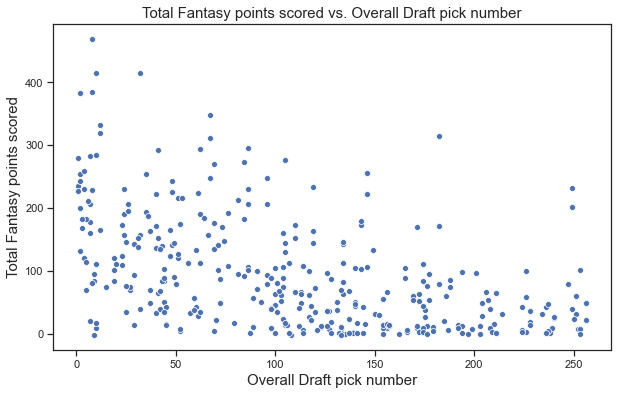

In [39]:
sns.set(style="ticks")
plt.figure(figsize=(10, 6))
ax = sns.scatterplot(x="Pick", y="fantasy_points",data=fantasy_draft_merged)
plt.xlabel('Overall Draft pick number', fontsize=15)
plt.ylabel('Total Fantasy points scored', fontsize=15)
plt.title('Total Fantasy points scored vs. Overall Draft pick number', fontsize=15);

#### We can see from the above graph that players drafted later (higher number) tend to score fewer fantasy points. We can determine the exact correlations for each position group by grouping the dataframe by the position variable and then applying the .corr() method. From below, we see that the QB position has the strongest correlation (-0.66) between draft position (Pick) and total fantasy points scored. This means that QB's drafted later tend to score fewer fantasy points. This makes sense because QBs drafted early usually start right away, while QB's selected later are often backups that rarely play in their first few seasons. We can also see that TEs have the weakest correlation (-0.36), which is almost half the value of the QBs correlation. This data is limited in scope to the draft years and fantasy years of 2017 to 2019. This means that there are no players in the dataset with more than three years of experience.

In [40]:
fantasy_draft_grouped = fantasy_draft_merged.groupby(['position'])[['Pick','fantasy_points']]
fantasy_draft_grouped.corr()

Pick  fantasy_points
position                                         
QB       Pick            1.000000       -0.662938
         fantasy_points -0.662938        1.000000
RB       Pick            1.000000       -0.559693
         fantasy_points -0.559693        1.000000
TE       Pick            1.000000       -0.357099
         fantasy_points -0.357099        1.000000
WR       Pick            1.000000       -0.499280
         fantasy_points -0.499280        1.000000

#### We can visualize the above correlations between the pick number and fantasy points scored for each position by plotting scatterplots for each position.

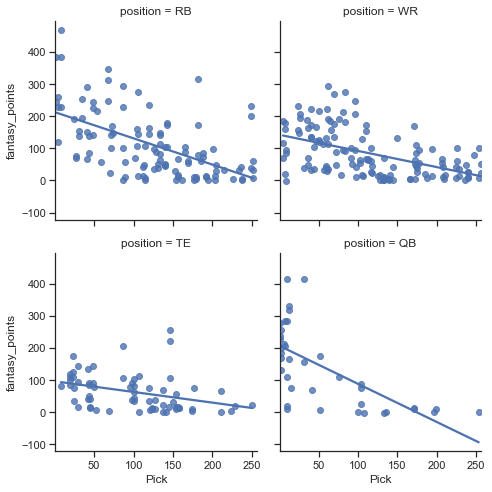

In [41]:
sns.set(style="ticks")
sns.lmplot(x="Pick", y="fantasy_points", data=fantasy_draft_merged,
           col='position',col_wrap=2, height=3.5,ci=None);

#### Next, we will create a bar plot to compare the average fantasy points scored across all draft rounds for all each position group. This will provide insight on which position groups score the most fantasy points in each round. From the bar plot below, we can see that running backs drafted in the first three rounds score more fantasy points than the other positions groups drafted in the same rounds. Surprisingly, the number of fantasy points scored by wide receivers was nearly identical in each of the first three rounds. 

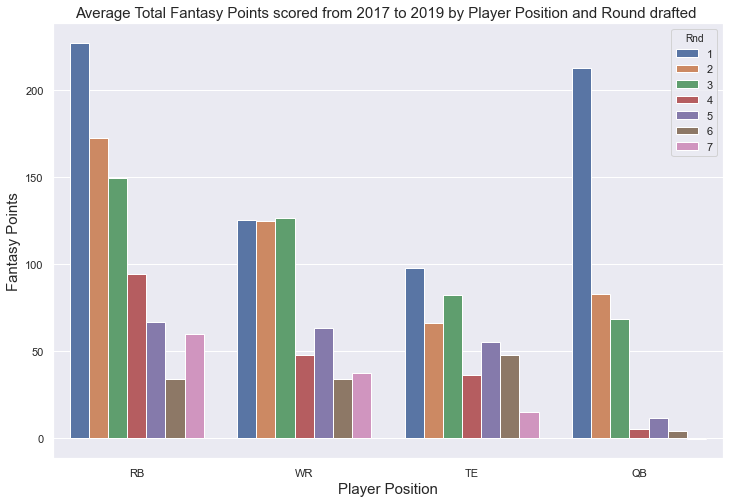

In [42]:
sns.set()
plt.figure(figsize=(12,8))
sns.barplot(x = 'position', y = 'fantasy_points', hue='Rnd',
            data = fantasy_draft_merged, ci=None)
plt.title('Average Total Fantasy Points scored from 2017 to 2019 by \
Player Position and Round drafted ', fontsize=15)
plt.xlabel('Player Position', fontsize=15)
plt.ylabel('Fantasy Points',fontsize=15);

#### We can see from the bar plot that players drafted in earlier rounds tend to score more fantasy points. To better visualize this relationship, we will construct and graph an empirical cumulative distribution function for the number of fantasy points scored by players in the first five rounds. The following ECDF function was taken from https://campus.datacamp.com/courses/statistical-thinking-in-python-part-1/graphical-exploratory-data-analysis?ex=14.

In [43]:
def ecdf(data):
    """Compute ECDF for a one-dimensional array of measurements."""
    
    # Number of data points: n
    n = len(data)

    # x-data for the ECDF: x
    x = np.sort(data)

    # y-data for the ECDF: y
    y = np.arange(1, n+1) / n

    return x, y

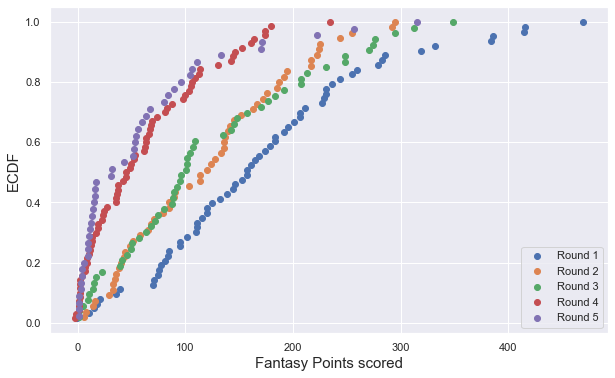

In [44]:
# Compute ECDFs for fantasy points scored for each of the first five rounds

sns.set()
plt.figure(figsize=(10, 6))
x_1, y_1 = ecdf(fantasy_draft_merged[fantasy_draft_merged['Rnd']==1]['fantasy_points'])
x_2, y_2 = ecdf(fantasy_draft_merged[fantasy_draft_merged['Rnd']==2]['fantasy_points'])
x_3, y_3 = ecdf(fantasy_draft_merged[fantasy_draft_merged['Rnd']==3]['fantasy_points'])
x_4, y_4 = ecdf(fantasy_draft_merged[fantasy_draft_merged['Rnd']==4]['fantasy_points'])
x_5, y_5 = ecdf(fantasy_draft_merged[fantasy_draft_merged['Rnd']==5]['fantasy_points'])


# Plot all ECDFs on the same plot
_ = plt.plot(x_1, y_1, marker='o', linestyle='none')
_ = plt.plot(x_2, y_2, marker='o', linestyle='none')
_ = plt.plot(x_3, y_3, marker='o', linestyle='none')
_ = plt.plot(x_4, y_4, marker='o', linestyle='none')
_ = plt.plot(x_5, y_5, marker='o', linestyle='none')


# Annotate the plot
_ = plt.legend(('Round 1', 'Round 2', 'Round 3','Round 4','Round 5'), loc='lower right')
_ = plt.xlabel('Fantasy Points scored', fontsize=15)
_ = plt.ylabel('ECDF', fontsize=15)

# Display the plot
plt.show()

#### From the ECDFs above, we can see that players drafted in the first round scored more fantasy points across nearly the entire distribution. Players selected in the second and third rounds had close scores across much of the distribution, but they scored much higher than players drafted in the fourth and fifth rounds.

### ***Merge #2:*** Merging the NFL Draft data with the NFL Combine data on the player column.

In [45]:
stmt = select([Draft_data, Combine_data])
stmt = stmt.select_from(Draft_data.join(Combine_data,
                                        Draft_data.columns.Player == Combine_data.columns.Name))
#stmt = stmt.where(Fantasy_data.columns.stats_year == 2018)

results = connection.execute(stmt).fetchall()
draft_combine_merged = pd.DataFrame(results, columns = results[0].keys())
draft_combine_merged = draft_combine_merged.drop_duplicates(["Draft_year","Player"])

print(results[0].keys())

['Rnd', 'Pick', 'Team', 'Player', 'Pos', 'Age', 'Draft_year', 'G', 'Pass_comp', 'Pass_att', 'Pass_yds', 'Pass_TD', 'Pass_Int', 'Rush_att', 'Rush_yds', 'Rush_TD', 'Receptions', 'Rec_yds', 'Rec_TD', 'Def_Tackles', 'Def_Int', 'Def_Sacks', 'College', 'Year', 'Name', 'POS', 'Height', 'Weight', 'Hand_Size', 'Arm_Length', 'Forty_Yard', 'Bench_Press', 'Vert_Leap', 'Broad_Jump', 'Shuttle']


#### I am a fan of the Green Bay Packers, so I am interested to see how teams in the same division (the NFC North) as the Packers performed in these drafts. One way to compare the teams is to visualize the number of draft picks that each team in the NFC North had during the 2017, 2018, and 2019 combined drafts.

In [46]:
# First we create a teams in the NFL North.
teams = ['CHI','GNB','MIN','DET']

# Next we create a df containing only teams from the NFC North
nfc_north_df = draft_combine_merged[draft_combine_merged.Team.isin(teams)]

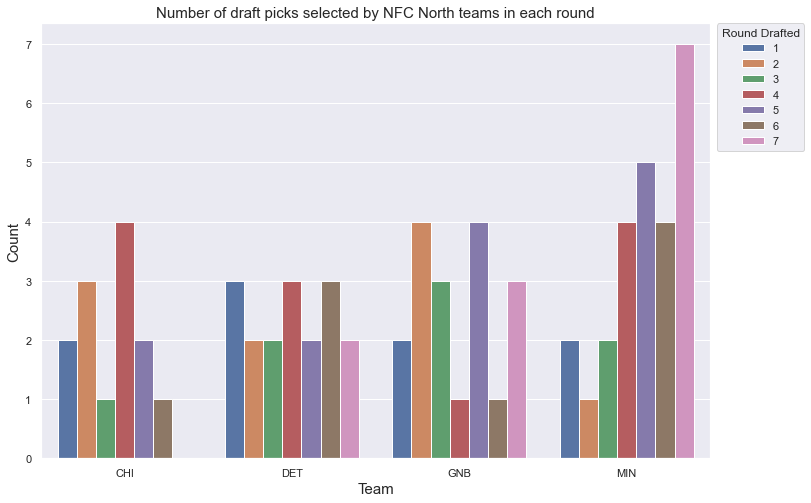

In [47]:
sns.set()
plt.figure(figsize=(12,8))
ax = sns.countplot(x = 'Team', hue='Rnd', data = nfc_north_df)
ax.set_title('Number of draft picks selected by NFC North teams in each round', fontsize=15)
ax.set_xlabel('Team', fontsize=15)
ax.set_ylabel('Count',fontsize=15)
ax.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.).set_title('Round Drafted')

#### Next, we will visualize the average number of games played by the draft picks.

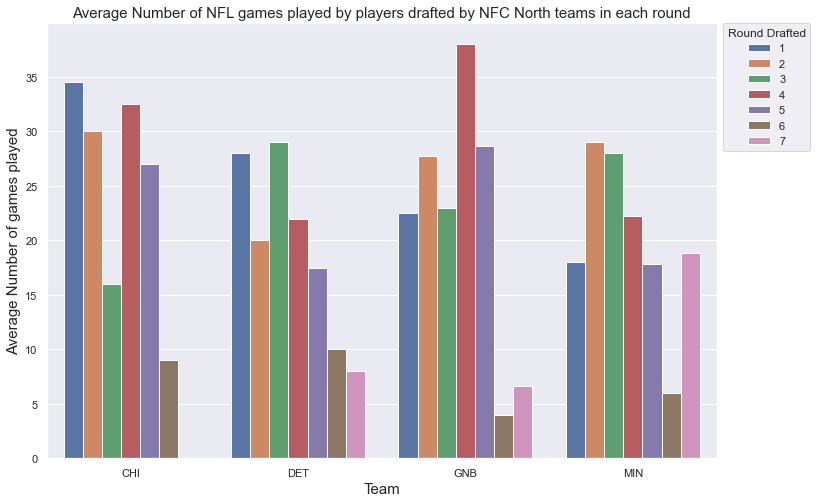

In [48]:
plt.figure(figsize=(12,8))
ax = sns.barplot(x = 'Team', y = 'G', hue='Rnd', data = nfc_north_df, ci=None)
ax.set_title('Average Number of NFL games played by players drafted\
 by NFC North teams in each round', fontsize=15)
ax.set_xlabel('Team', fontsize=15)
ax.set_ylabel('Average Number of games played',fontsize=15)
ax.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.).set_title('Round Drafted')

#### In the graph above, we can see that Green Bay finished third place when comparing the number of games played by draft picks from the first three rounds. However, Green Bay finished first when comparing the number of games played by draft picks from the fourth and fifth rounds. This could be an indication that Green Bay is finding value in the later rounds of the draft.

#### Before generating the heatmap of correlations, we will identify what the variables are and what they mean. Understanding the direction of favorability will make it easier to interpret the results.    
Pick - Represents when the player was chosen in the draft. Lower is better.  
G - Compiled after the draft, and represents how many games the player has played in the NFL so far. Higher is better.  
Forty_Yard - The elapsed time to run a forty-yard dash. Lower is better.  
Bench_Press - The number of barbell bench press repetitions completed with 225 lb. Higher is better.  
Vert_Leap - The vertical distance a player jumps from a standstill position. Higher is better.  
Broad_Jump - The horizontal distance a player jumps from a standstill position. Higher is better.  
Shuttle - The elapsed time to run a 20-yard shuttle. Lower is better.  

#### Next, we will create a heatmap showing the correlations between the overall draft pick number (Pick), the number of games played (G), the Forty Yard dash time (Forty_Yard), the number of Bench press repetitions (Bench_Press), the Vertical leap height (Vert_Leap), the Broad jump distance (Broad_Jump) and the time to perform the 20-yard shuttle (Shuttle). The first two variables are from the Draft_data table, and the last five variables are from the Combine_data table.

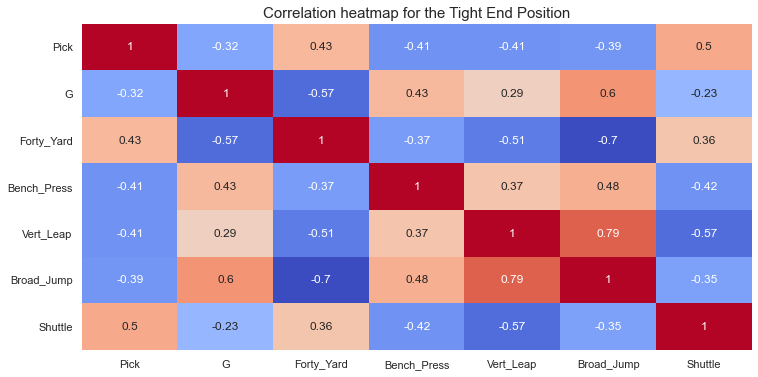

In [49]:
# Choose the columns to be used in the correlation heatmap.
cols = ['Pick','G','Forty_Yard', 'Bench_Press', 'Vert_Leap', 'Broad_Jump', 'Shuttle']
plt.figure(figsize=(12, 6))
# Create the correlation heatmap for these variables for the Tight End position only.
sns.heatmap(draft_combine_merged[draft_combine_merged['POS']=='TE'][cols].corr(),
            annot = True, cbar=False, fmt='.2g',cmap= 'coolwarm')
plt.title('Correlation heatmap for the Tight End Position', fontsize=15);

#### In the first two columns in the above heatmap, we can see that for the Tight End position, the player's draft position was moderately correlated to all the athletic drill measurements at the NFL Combine. Furthermore, the athletic drill measurements were moderately correlated to the number of games a Tight End is expected to play in the NFL. The correlation between Broad_Jump and Games played equals 0.6. We will create a scatterplot between these two variables to visualize this result.

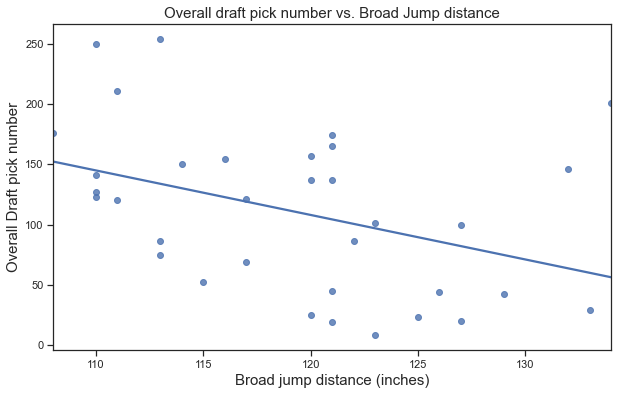

In [50]:
sns.set(style="ticks")
plt.figure(figsize=(10, 6))
sns.regplot(x="Broad_Jump", y="Pick",
            data=draft_combine_merged[draft_combine_merged['POS']=='TE'], ci=None)
plt.xlabel('Broad jump distance (inches)', fontsize=15)
plt.ylabel('Overall Draft pick number', fontsize=15)
plt.title('Overall draft pick number vs. Broad Jump distance', fontsize=15);

#### We will compare the previous heatmap of Tight Ends to the heatmap of all player positions for the same variables.

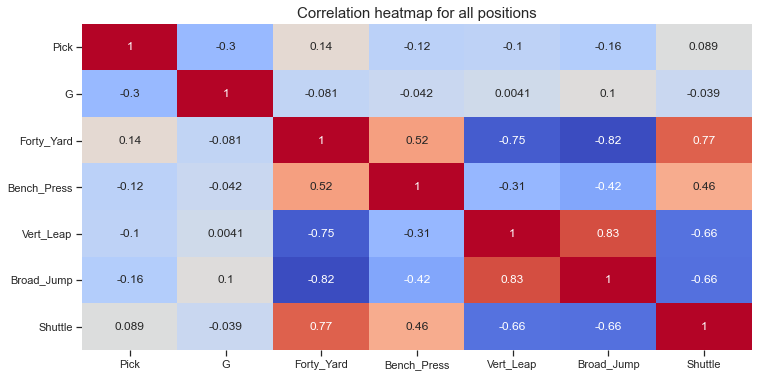

In [51]:
# Using the same columns as before, we create the correlation heatmap for all positions.
plt.figure(figsize=(12, 6))
sns.heatmap(draft_combine_merged[cols].corr(), annot = True,
            cbar=False, fmt='.2g',cmap= 'coolwarm')
plt.title('Correlation heatmap for all positions', fontsize=15);

#### We can see from the heatmap of all positions that the player's draft position was weakly correlated to all the athletic NFL Combine measurements. Furthermore, there is almost no correlation between the athletic drill measurements and the number of games a player is expected to play in the NFL. This could indicate that NFL Personnel departments evaluate Tight Ends differently than other positions at the NFL Combine.

#### College football fans might be interested to know which Colleges had the most players drafted. We will use value_counts() to find the top 15 Colleges with the most players drafted.

In [52]:
draft_combine_merged['College'].value_counts()[:15]

Alabama               25
Ohio St.              21
Washington            18
Florida               16
Miami (FL)            16
Michigan              15
LSU                   15
Texas A&M             13
Oklahoma              13
Clemson               13
Wisconsin             12
Georgia               12
North Carolina St.    12
Auburn                12
Mississippi           11
Name: College, dtype: int64

#### From the above, we can see that Alabama had 25 players drafted during the combined 2017, 2018, and 2019 drafts. To visualize the top 15 results, we will create a list of the teams and then create a new dataframe containing only the top 15 teams.

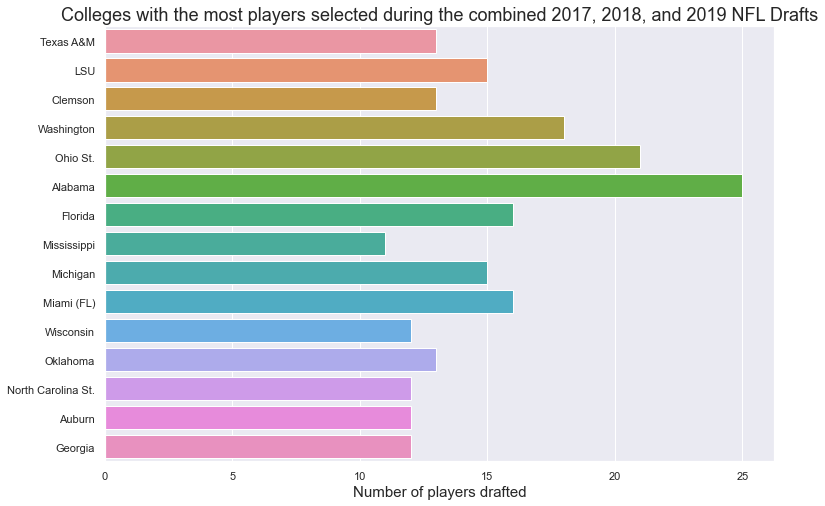

In [53]:
myteams = draft_combine_merged['College'].value_counts()[:15].index
top_fifteen_colleges = draft_combine_merged[draft_combine_merged['College'].isin(myteams)]
sns.set()
plt.figure(figsize=(12, 8))
sns.countplot(y='College', data=top_fifteen_colleges)
plt.title('Colleges with the most players selected during the combined 2017,\
 2018, and 2019 NFL Drafts', fontsize=18)
plt.xlabel('Number of players drafted', fontsize=15)
plt.ylabel('', fontsize=15);

#### From the above plot, we can see that Alabama lead the way with 25 draft players selected. Die-hard College fans might be even more curious to know, for the top 15 results above, which conference had the most players drafted in each round during the 2017 to 2019 drafts. We can find out by first creating a map of the 15 teams to their conferences. Next, we apply the map to create a Conference column in the dataframe and plot the results using a count plot. ***NOTE:*** The count plot below is not complete, as we are only including the top 15 colleges in the map. We would need to map all 131 Colleges to their conferences to have a complete count of how many players were selected by each conference.

In [54]:
# Map each team to it's corresponding conference.
team_to_conference = { 'Alabama': 'SEC', 'Ohio St.': 'Big Ten', 'Washington': 'PAC-12', 'Florida': 'SEC',
                      'Michigan': 'Big Ten', 'Miami (FL)': 'ACC', 'LSU': 'SEC','Clemson': 'ACC', 'Texas A&M': 'SEC',
                      'Oklahoma': 'Big 12', 'Auburn': 'SEC', 'Georgia': 'SEC', 'Wisconsin': 'Big Ten', 
                      'North Carolina St.': 'ACC', 'Iowa': 'Big Ten', 'Wisconsin': 'Big Ten' }

# Create the Conference column by applying the map to the College column.
top_fifteen_colleges['Conference'] = top_fifteen_colleges['College'].map(team_to_conference)

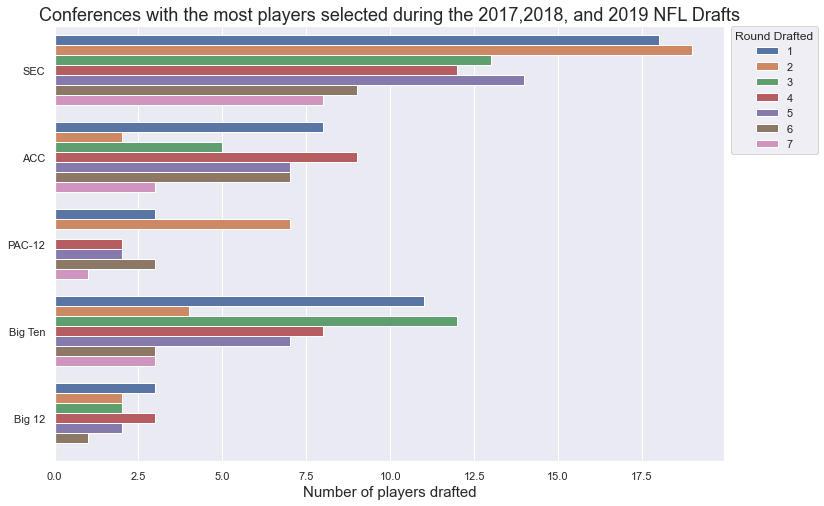

In [55]:
plt.figure(figsize=(12, 8))
ax = sns.countplot(y='Conference', hue='Rnd', data=top_fifteen_colleges)
ax.set_title('Conferences with the most players selected during the 2017,2018, and 2019 NFL Drafts', fontsize=18)
ax.set_xlabel('Number of players drafted', fontsize=15)
ax.set_ylabel('')
ax.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.).set_title('Round Drafted')

#### From the above graph, we can see that the SEC conference had the most players selected in all but two rounds of the draft. In those (third and fourth) rounds, the SEC was tied with the Big Ten for the number of players selected. Again, this count is not complete, as we only included the top 15 colleges.

### ***Merge #3:*** Merging the NFL Fantasy data with the NFL Combine data on the player column.

In [56]:
stmt = select([Fantasy_data, Combine_data])
stmt = stmt.select_from(Fantasy_data.join(Combine_data, Fantasy_data.columns.player_name == Combine_data.columns.Name))

results = connection.execute(stmt).fetchall()
fantasy_combine_merged = pd.DataFrame(results, columns = results[0].keys())
fantasy_combine_merged = fantasy_combine_merged.drop_duplicates(["stats_year","player_name"])

print(results[0].keys())

['stats_year', 'fumbles_lost', 'games_played', 'player_name', 'position', 'team', 'int', 'passing_att', 'passing_cmp', 'passing_td', 'passing_yds', 'receiving_td', 'receiving_yds', 'receptions', 'targets', 'rushing_att', 'rushing_td', 'rushing_yds', 'fantasy_points', 'Year', 'Name', 'POS', 'Height', 'Weight', 'Hand_Size', 'Arm_Length', 'Forty_Yard', 'Bench_Press', 'Vert_Leap', 'Broad_Jump', 'Shuttle']


#### First we will look at how many fantasy points were scored by the players in our dataset during each of the past three years. 

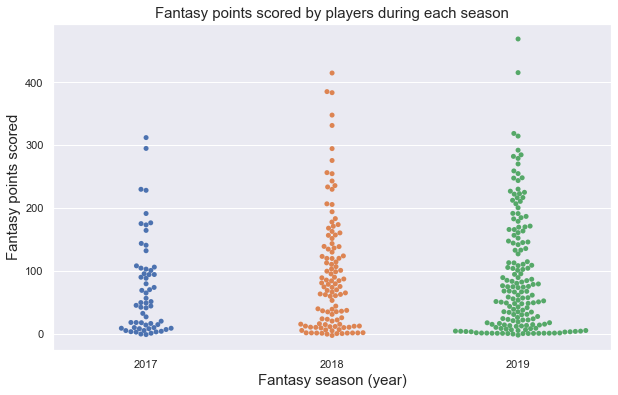

In [57]:
plt.figure(figsize=(10, 6))
sns.swarmplot(x = 'stats_year', y = 'fantasy_points' ,data = fantasy_combine_merged)
plt.title('Fantasy points scored by players during each season', fontsize=15)
plt.xlabel('Fantasy season (year)', fontsize=15)
plt.ylabel('Fantasy points scored',fontsize=15);

####  From above, players in our dataset scored the fewest points in the year 2017, with scores increasing in 2018 and 2019. Why did this happen? It is because of how our dataset was constructed. The 2017 'stats_year' contains only players drafted in 2017 because they were the only ones who participated in the 2017 NFL combine. The 2018 'stats_year' contains players from both the 2017 and 2018 NFL combines, and the year 2019's stats_year' includes players from all three (2017,2018, and 2019) NFL combines. Instead, we will use the 'Year' variable, which represents the year the player participated in the combine. While not explicitly stated, the 'Year' variable is a proxy variable indicating the year the player started in the NFL. We will create a bar plot below comparing the NFL combine 'Year' to the average number of fantasy points.

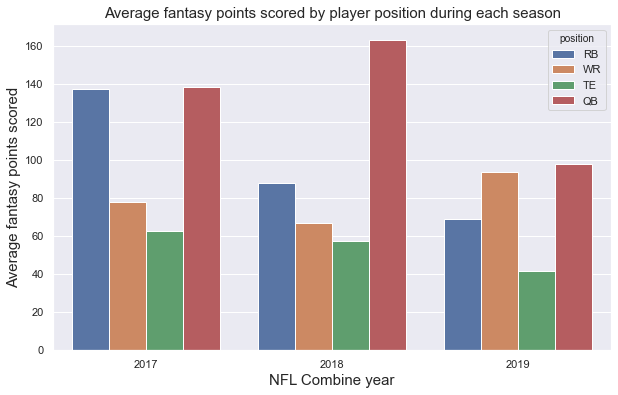

In [58]:
sns.set()
plt.figure(figsize=(10, 6))
sns.barplot(x = 'Year', y = 'fantasy_points', hue='position', data = fantasy_combine_merged,ci=None)
plt.title('Average fantasy points scored by player position during each season', fontsize=15)
plt.xlabel('NFL Combine year', fontsize=15)
plt.ylabel('Average fantasy points scored',fontsize=15);

#### Finally, we will visualize how the NFL combine drills correlate to the number of fantasy points scored for each position group. We will do this by first creating a list containing only the relevant columns. We then group the dataframe of these relevant columns by 'position'. Finally, we create a heatmap by applying the .corr() method and selecting the 'fantasy_points' column. From the heatmap below, we see that Tight Ends had the strongest correlations across most of the drills. This is likely due to faster Tight Ends exploiting mismatches against slower linebackers and lineman in coverage.

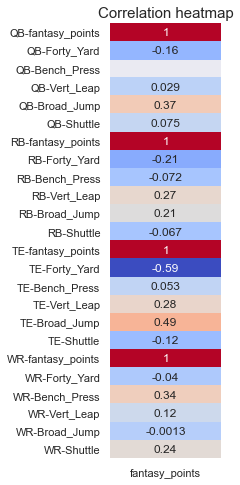

In [59]:
mycols = ['fantasy_points','Forty_Yard', 'Bench_Press', 'Vert_Leap', 'Broad_Jump', 'Shuttle']
fantasy_combine_grouped = fantasy_combine_merged.groupby('position')[mycols]

plt.figure(figsize=(2, 8))
sns.heatmap(fantasy_combine_grouped.corr()[['fantasy_points']],
            annot = True, cbar=False, fmt='.2g',cmap= 'coolwarm')
plt.title('Correlation heatmap', fontsize=15)
plt.ylabel('');

## Conclusions

I enjoyed how this project enabled me to apply various steps of data wrangling to different real-world data sources. The most challenging part was learning how to scrape the data from the web, but looking back, this was also the most rewarding. Web scraping is a fascinating way to collect data from nearly any web page, and Beautiful Soup provided an intuitive yet powerful way to do it. Since I used a public API, I was able to skip the authentication step, but the API returned a nested JSON file. The nested JSON was challenging to parse and save into a dataframe until I discovered that pandas has a .json_normalize() method that unpacks the nested JSON. Another challenge I encountered was learning how to create a SQL database and upload the dataframes as tables into the database. Thankfully, Python has many libraries to support SQL database integration, and I chose SQLAlchemy to perform the imports and joins. Once the tables were uploaded into SQL, I exported them as Python dataframes and verified they were equal to the original dataframes using the df.equals(other_df) method. After joining the tables in SQL two at a time by player name, I exported the joined tables to Python. I then created visualizations in seaborn using data from both Tables. By using visualizations, I was able to explore various relationships that would not have been possible without joining the data together. The most important thing that I learned is that merging multiple data sources requires you to understand the original data and how combining the data can change the relationships within it. Without understanding your data, you can unwittingly misinterpret the meaning of your visualizations. Since the data sources were only from 2017 to 2019, the specific relationships discovered are likely overfitted within this period and would be different in other periods.